Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

In [5]:
band = 'g'
field = 'south'
region_name = 'decals_ngc'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = 0.262

In [6]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts']

# ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz')
if field=='south':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-decam-dr8.fits.gz', columns=ccd_columns)
elif field=='north' and band=='z':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-mosaic-dr8.fits.gz', columns=ccd_columns)
elif field=='north' and (band=='g' or band=='r'):
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-90prime-dr8.fits.gz', columns=ccd_columns)
else:
    raise ValueError
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

mask = ccd['dec']>-32
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

ccd[:1]

0.451153205656
0.825985645545


image_filename,image_hdu,camera,expnum,ccdname,filter,fwhm,ra,dec,ccd_cuts
bytes120,int16,bytes9,int64,bytes5,bytes1,float32,float64,float64,int64
decam/CPDES82/c4d_130901_031805_ooi_g_v1.fits.fz,11,decam,229341,S23,g,4.76996,318.671169787,1.37389746935,0


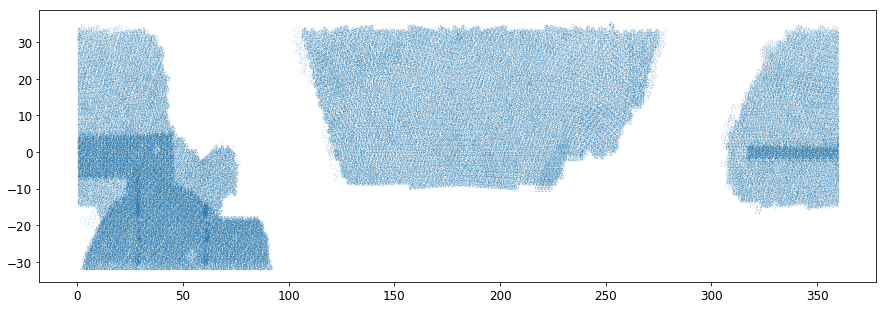

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

__Load polynomial fit__

In [8]:
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = 0.262
# pixscale = 0.262 # pixscale for cutout queries

tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

        5          4         3         2
-0.077 x - 0.2577 x + 1.984 x - 2.181 x - 3.396 x - 2.231


__Check that the fit works__

In [9]:
# ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
# ls_mag_bright = 6.5

# profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

# profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, region_name, band))

# xfit = np.logspace(-1, 2, 200)
# yfit = 10**(profile_fit(np.log10(xfit)))

# plt.figure(figsize=(11, 8))
# plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
#            label='fit', c='C0')
# # for index in range(len(ls_mag_bins)):
# for index in [0, 2, 4]:
#     # normalize the flux to 22.5 magnitude stars
#     norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale**2
#     x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
#     y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
#     plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
#                label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
# norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale**2
# x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
# y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
# plt.loglog(x, y, lw=1.5, alpha=1., ls=':',
#            label='{}mag = {:.2f}'.format(band, ls_mag_bright), c='r')
# plt.title('{} {} {}-band'.format(field, region_name, band))
# plt.axis([0.5, 80, 1e-9, 5e-2])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('SB (a.u.)')
# plt.legend()
# plt.show()

__Moffat fit__

In [10]:
ccd_mask = ccd['filter']==band
# ccd_mask &= (ccd['ra']>ra-dra) & (ccd['ra']<ra+dra) & (ccd['dec']>dec-ddec) & (ccd['dec']<dec+ddec)
ccd_mask &= (ccd['dec']<33) & (ccd['dec']>-30)
print(np.sum(ccd_mask))

idx = np.where(ccd_mask)[0]
nplot = 20
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)

1040338


754040 N1 g; FWHM = 1.89


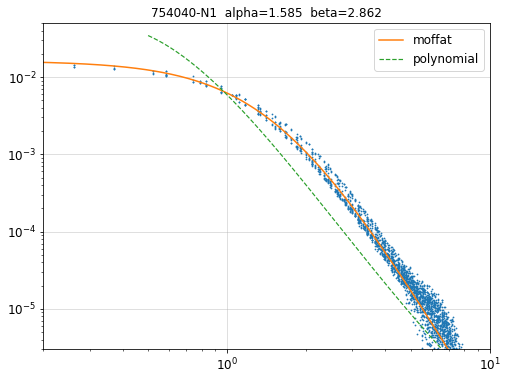

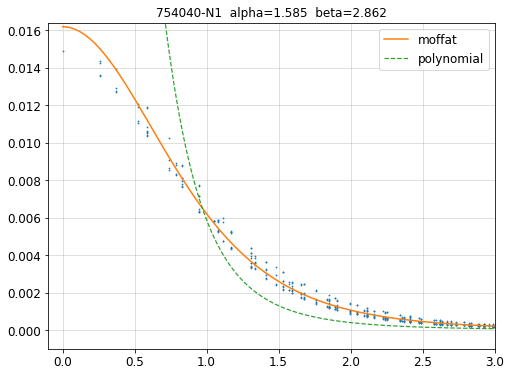

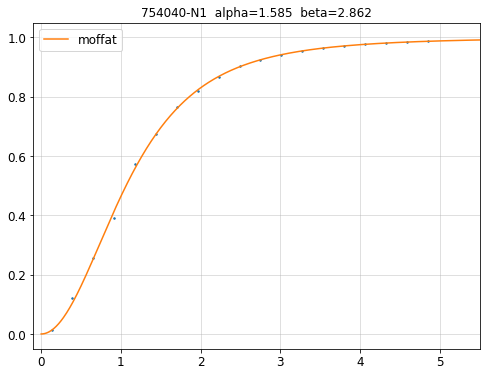

695316 S29 g; FWHM = 1.43


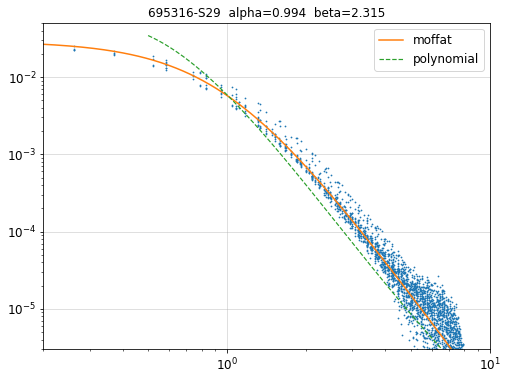

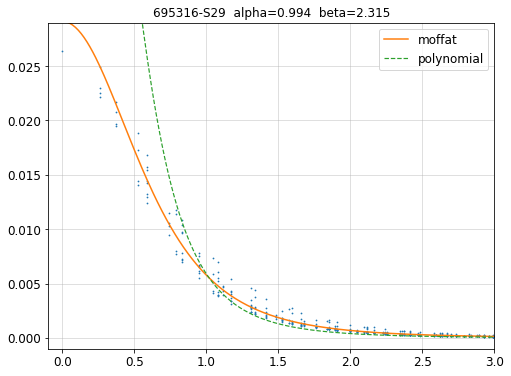

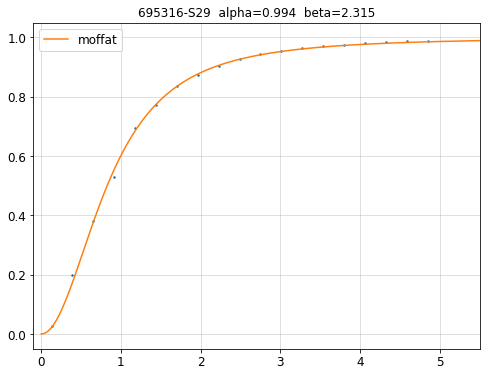

661622 S21 g; FWHM = 1.53


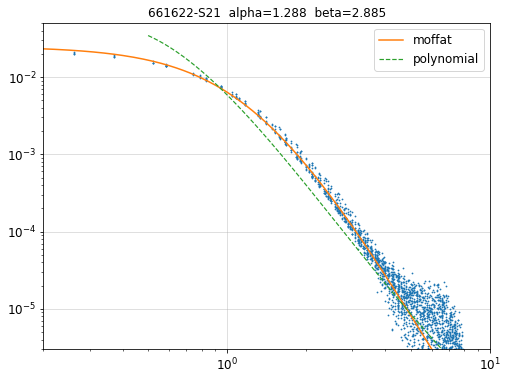

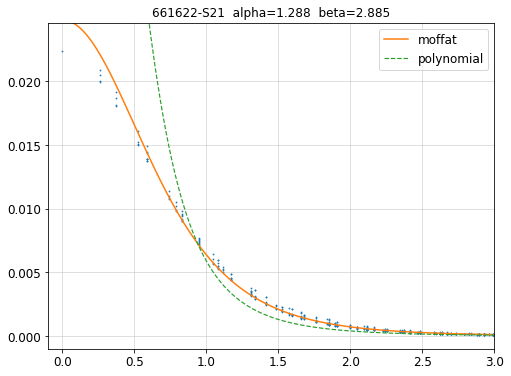

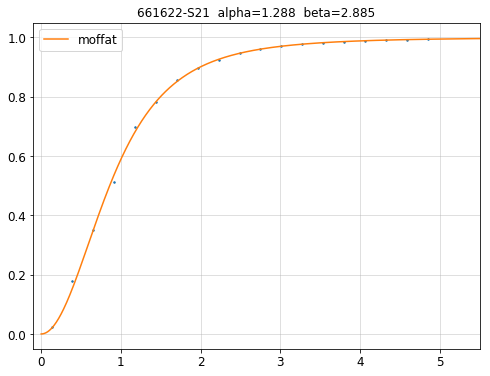

780707 S6 g; FWHM = 1.12


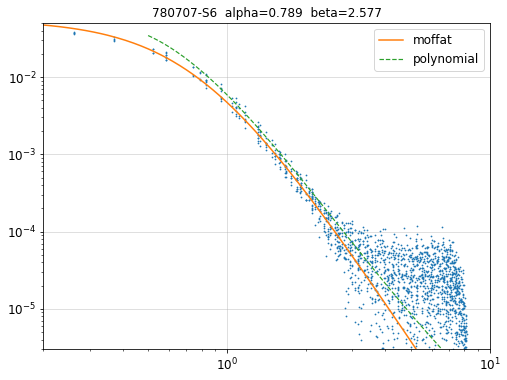

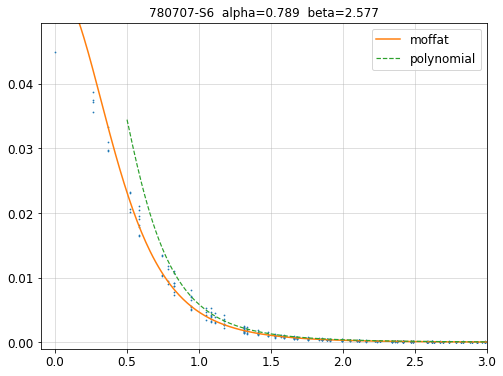

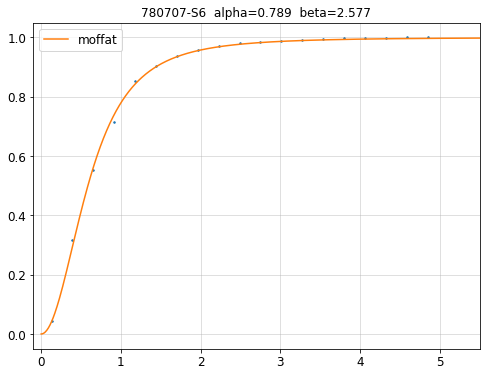

670316 N29 g; FWHM = 1.05


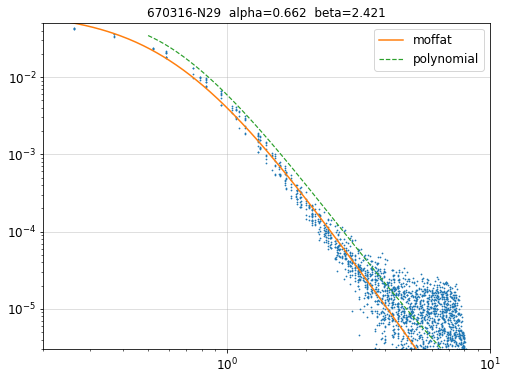

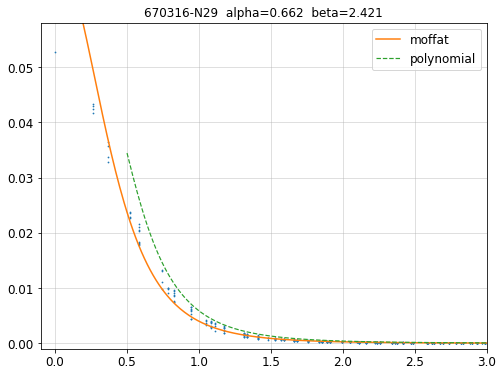

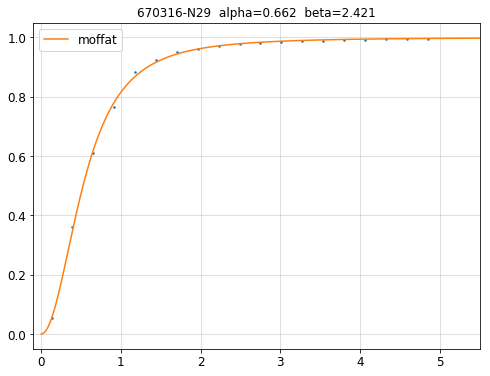

388627 N3 g; FWHM = 1.10


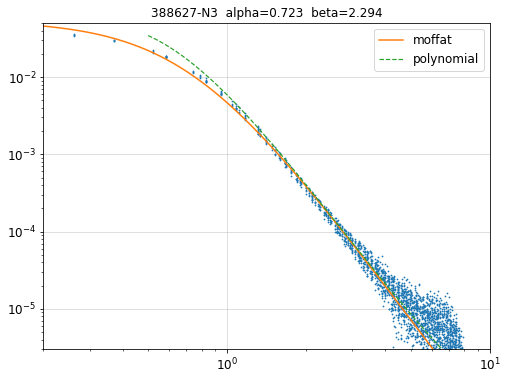

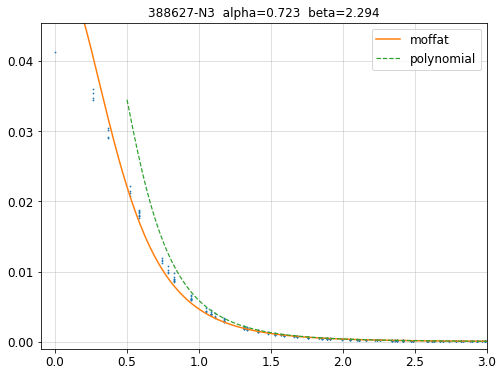

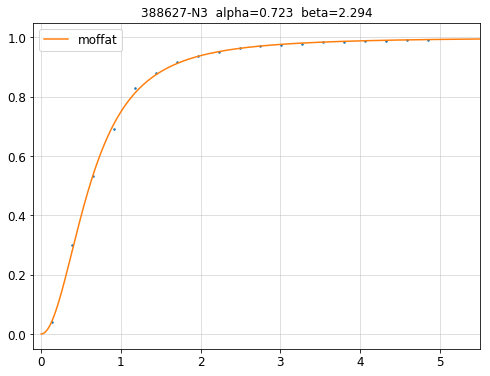

695040 N20 g; FWHM = 1.19


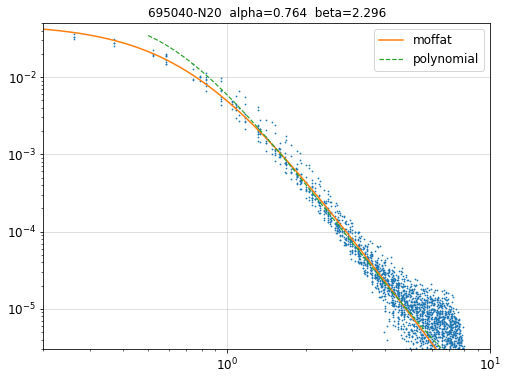

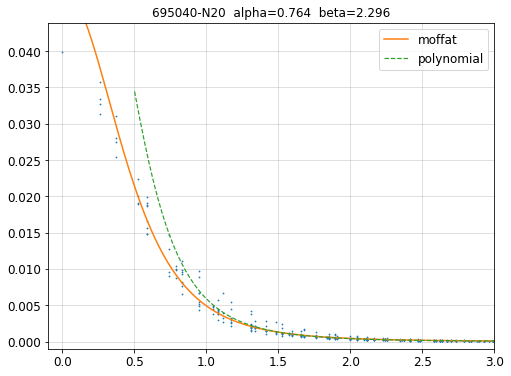

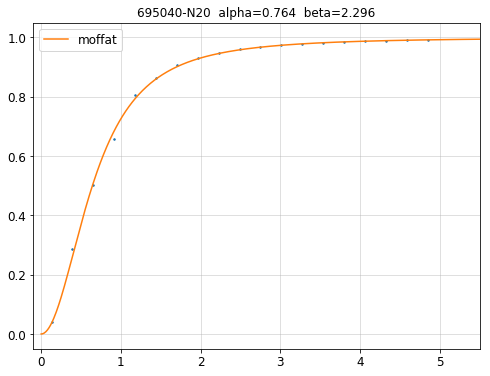

702297 S22 g; FWHM = 1.06


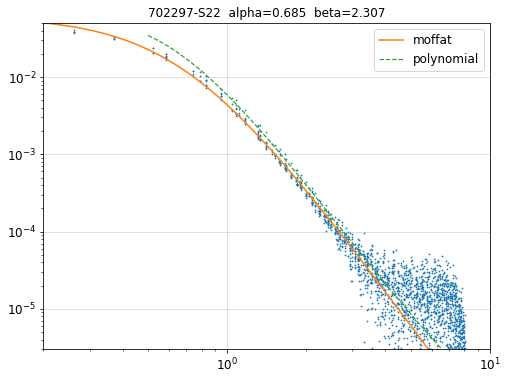

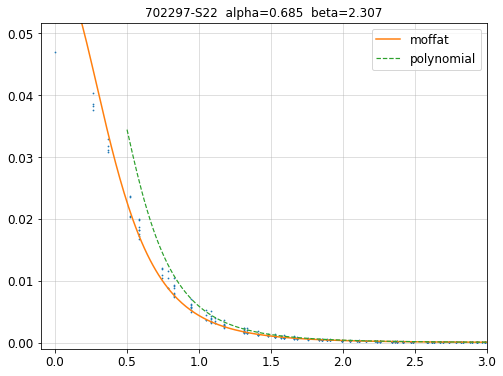

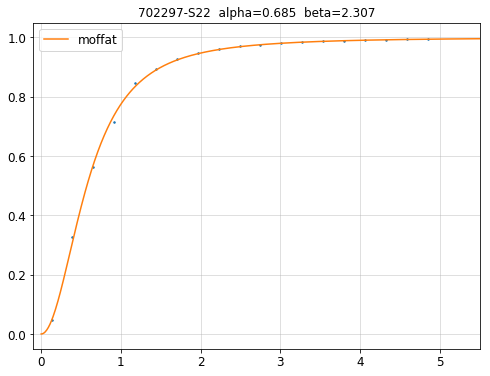

493274 N7 g; FWHM = 0.98


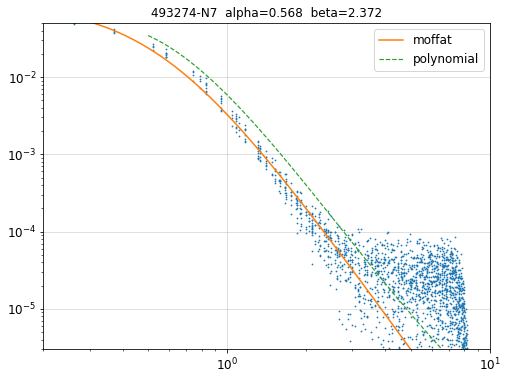

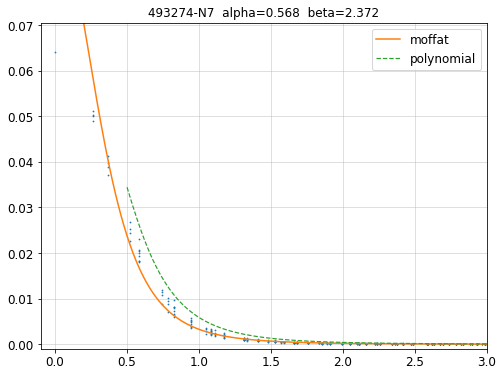

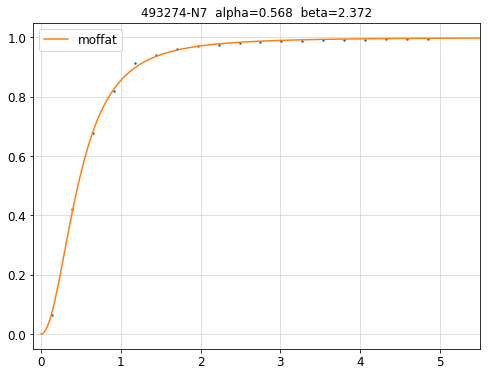

389511 N8 g; FWHM = 1.14


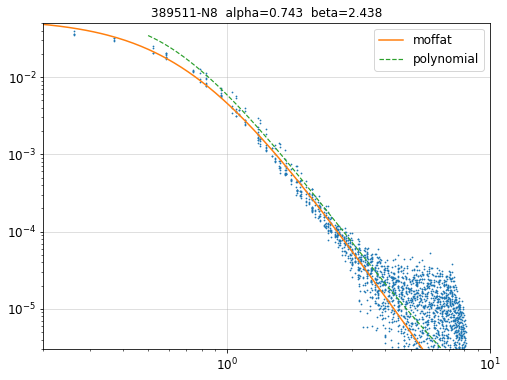

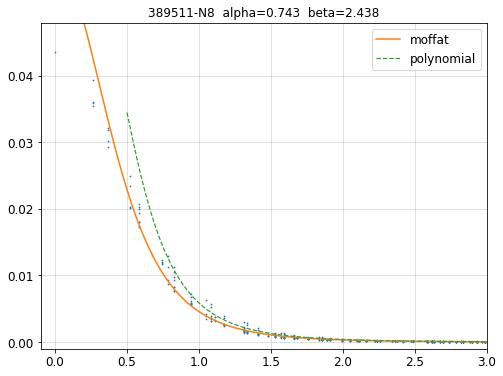

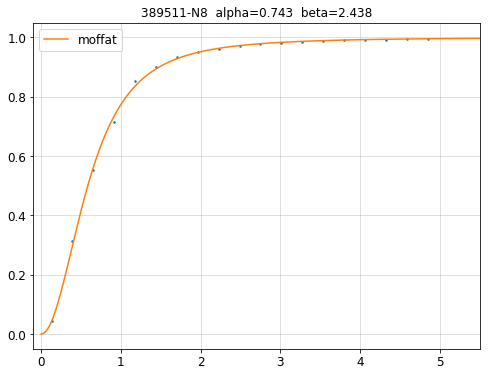

783049 N4 g; FWHM = 1.74


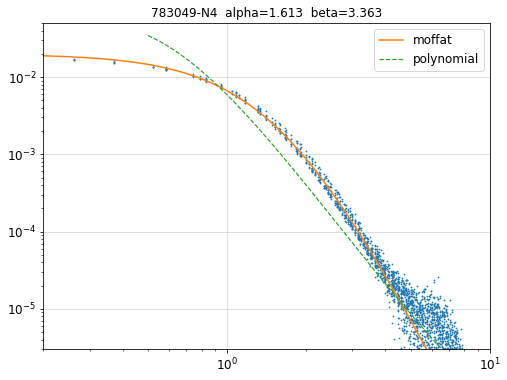

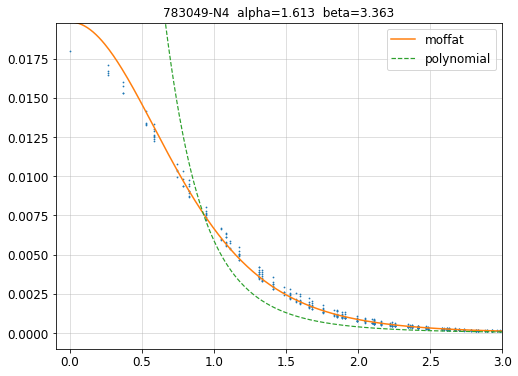

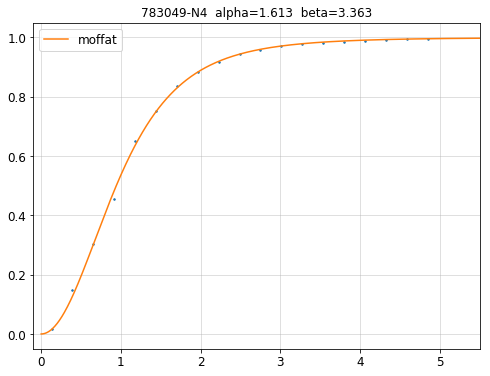

745773 S2 g; FWHM = 1.70


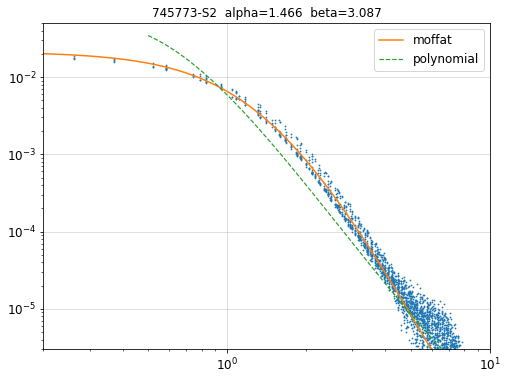

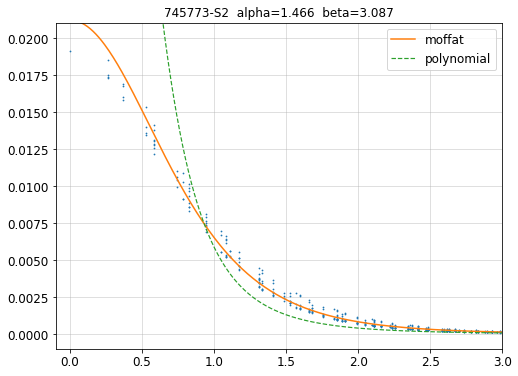

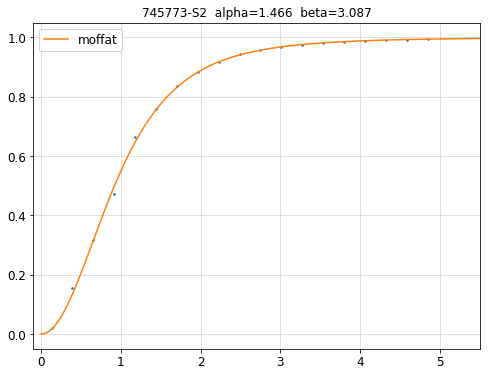

721471 N13 g; FWHM = 1.12


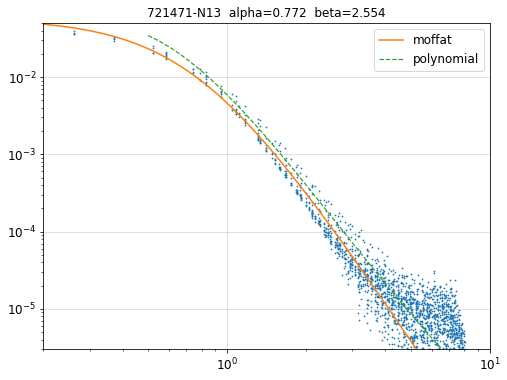

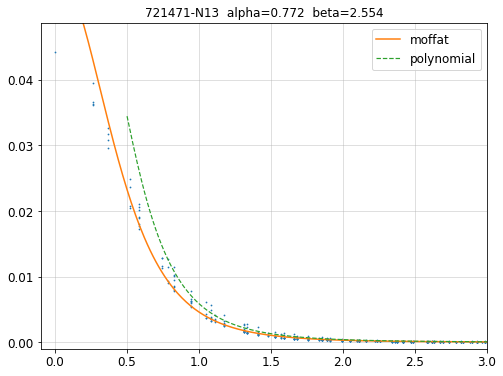

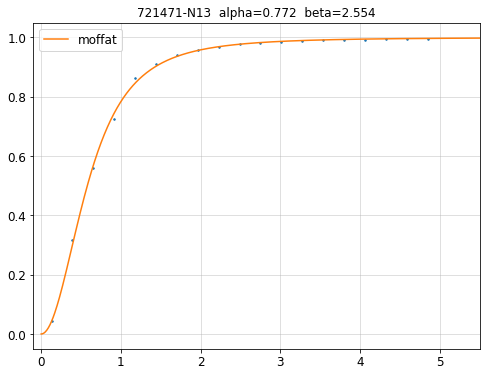

781386 S11 g; FWHM = 1.23


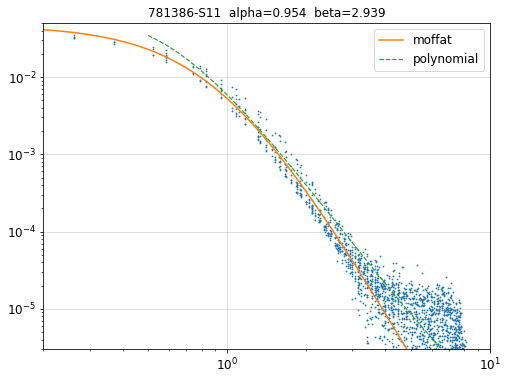

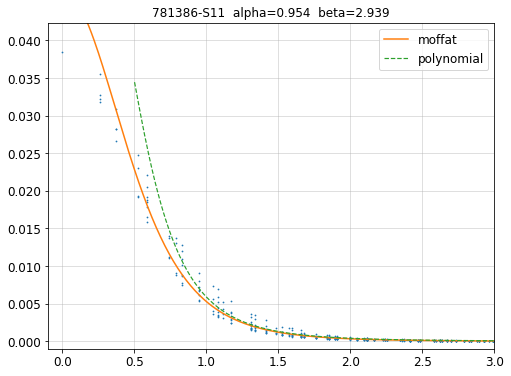

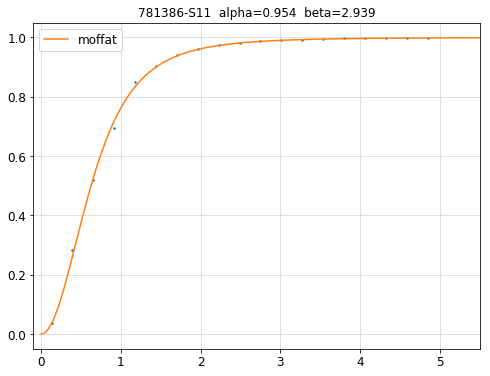

587070 N24 g; FWHM = 1.21


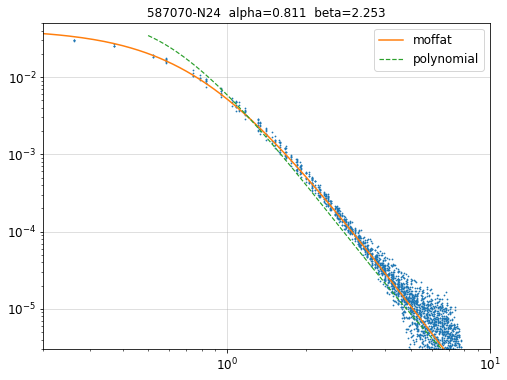

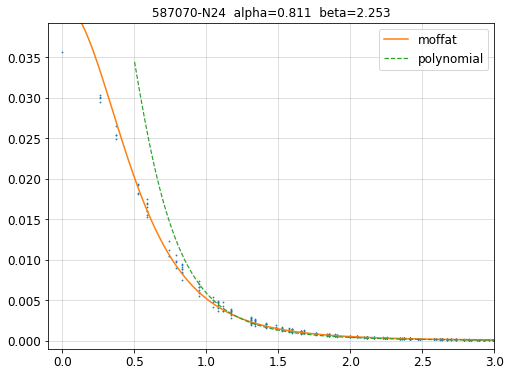

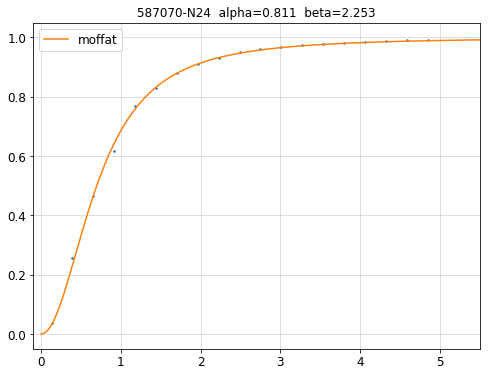

724578 S1 g; FWHM = 1.41


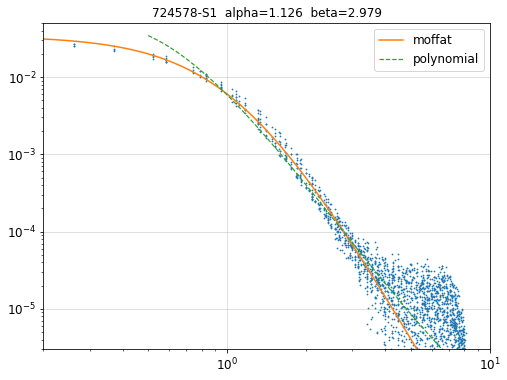

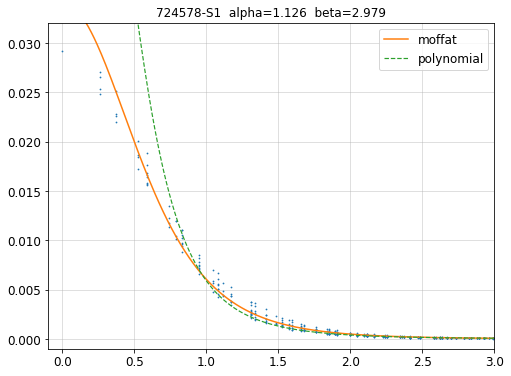

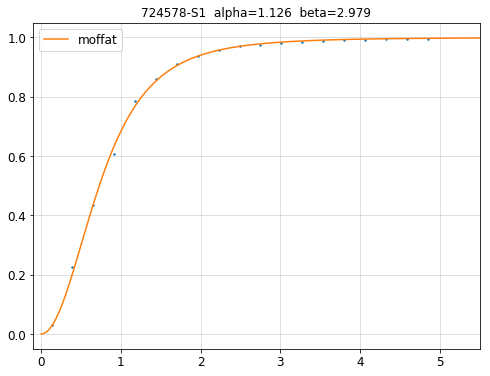

802330 S18 g; FWHM = 1.45


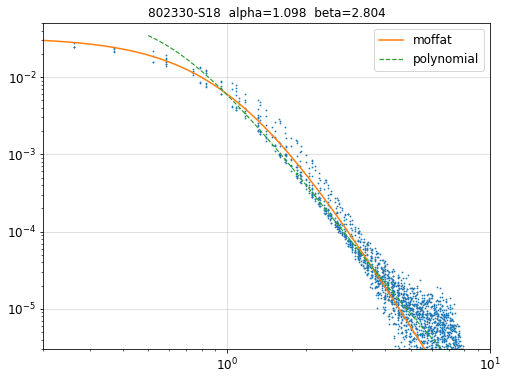

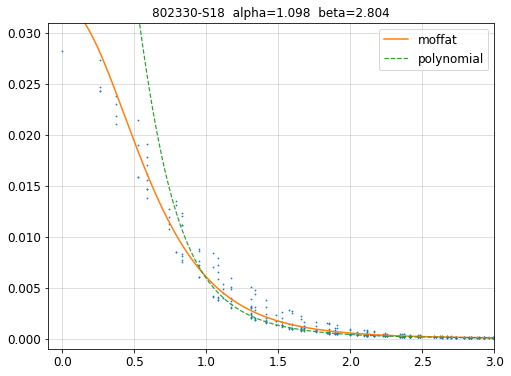

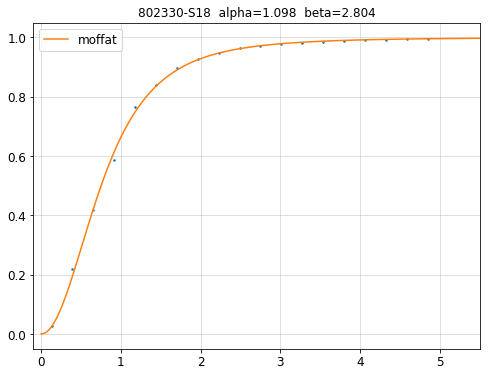

390913 S29 g; FWHM = 1.15


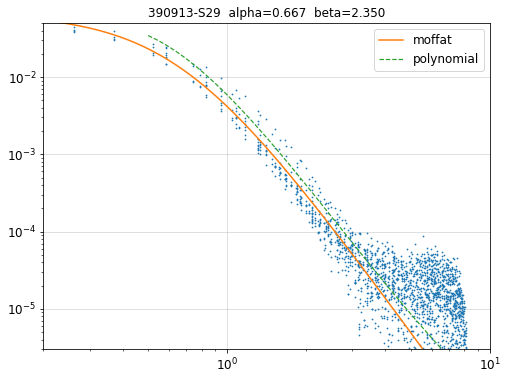

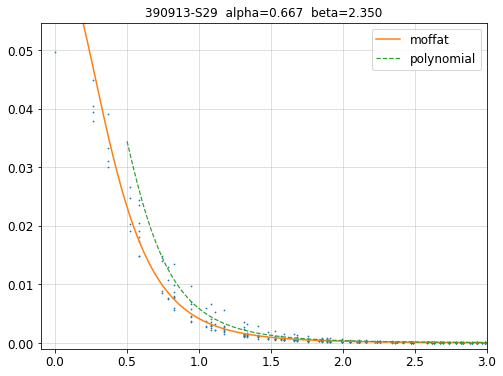

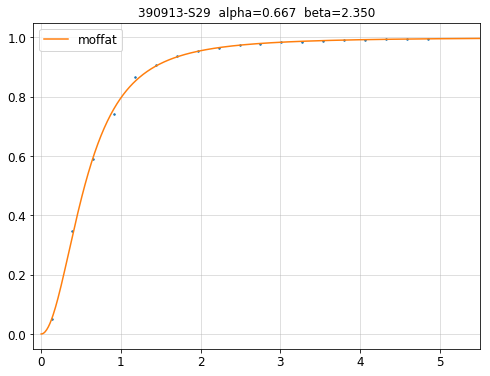

391706 S10 g; FWHM = 1.27


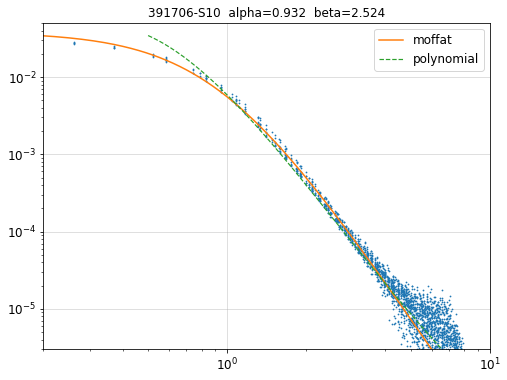

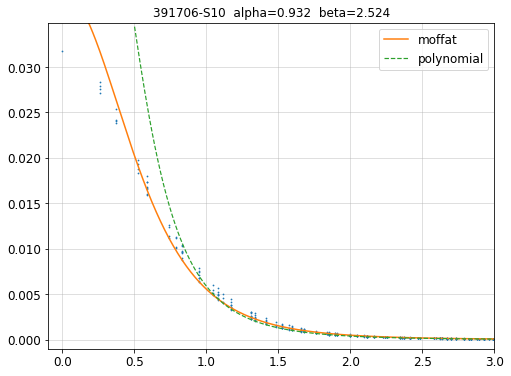

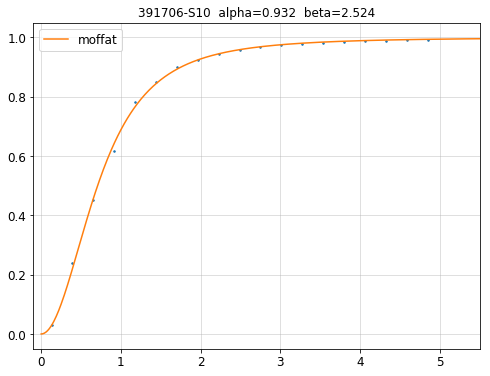

634372 S10 g; FWHM = 1.07


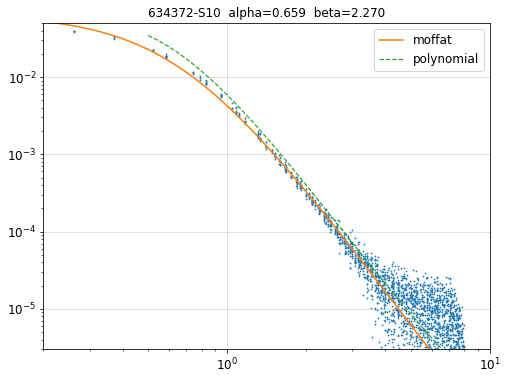

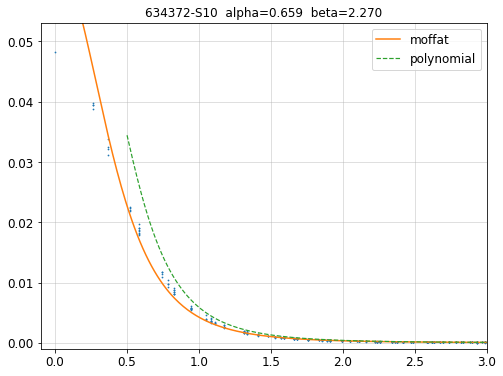

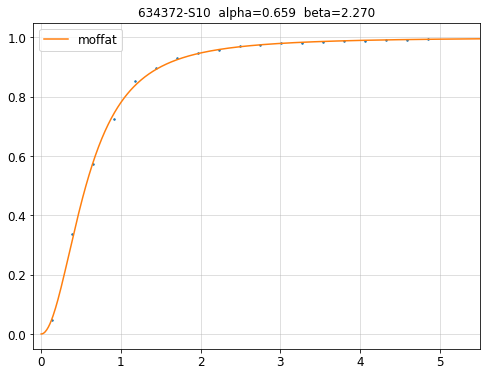

In [11]:
radius_min = pixscale/2
radius_max = 5.0

# for ccd_index in idx[:1]:
for ccd_index in idx:

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)
    if field=='south':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and band=='z':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and (band=='g' or band=='r'):
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
    else:
        raise ValueError
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf_all = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf_all[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)
    psf0_flat = psf0.flatten()

    grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    
    ################# Moffat fit ##############
    
    radius_arr = np.arange(radius_min, radius_max, pixscale)
    flux_frac = np.zeros(len(radius_arr))
    for index in range(len(radius_arr)):
        flux_frac[index] = np.sum(psf0_flat[radius<radius_arr[index]])/np.sum(psf0)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
        # print(popt)

    alpha, beta = popt
    flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
    psf_moffat_fit = pixscale**2 * get_sb_moffat(radius_arr, alpha, beta)

    radius_plot = np.linspace(0, 10, 1000)
    psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    
    ############################################
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        mask = radius_plot>0.5

        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.5)
        plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
        plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8, 6))
        plt.plot(radius, (psf0).flatten(), '.', ms=1.5)
        plt.plot(radius_plot, psf_moffat_plot, '-', label='moffat')
        plt.plot(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
        plt.axis([-0.1, 3, -0.001, 1.1*(psf0).flatten().max()])
        # plt.axis([-0.1, 10, -0.0001, 0.0001])
        plt.grid(alpha=0.5)
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8, 6))
        plt.plot(radius_arr, flux_frac, '.', ms=3)
        plt.plot(radius_plot, get_frac_moffat(radius_plot, alpha, beta), '-', label='moffat')
        plt.axis([-0.1, radius_max+0.5, -0.05, 1.05])
        plt.grid(alpha=0.5)
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        plt.show()